# Downstream analysis of HPLC-Orbitrap data

This notebook replicates the analysis workflow created by Marc Rurik. The workflow wrapped in [KNIME](https://www.knime.org/) nodes can be found [here](http://www.myexperiment.org/workflows/4792.html), and is illustrated in the picture below. The workflow is developed to analyze HPLC-Orbitrap measurements split into separate or alternating m/z scan ranges. The input expects to be OpenMS consensusXML files, generated by the TextExporter in OpenMS. The workflow further combines the scan ranges, filter them ultilizing blank samples and QC measurements, and then performs statistical analysis to retrieve reliable features.

The aim of this notebook is to give an user friendly and interactive environment where you can get on-the-fly information about the progress of your data. After each step of the pipeline, we provide you with live feedback, consisting of informative plots.

<p align="center">
  <img src="http://www.myexperiment.org/workflows/4792/versions/1/previews/full"/>
</p>

Illustration by: Marc Rurik

* Source .rscripts

In [1]:
source('../reproducing/Functions.R')

[1] "The functions were succesfully loaded"


In [2]:
library(R.utils)

Warning message:
"package 'R.utils' was built under R version 3.3.3"Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.7.1 (2016-02-15) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.21.0 (2016-10-30) successfully loaded. See ?R.oo for help.

Attaching package: 'R.oo'

The following objects are masked from 'package:methods':

    getClasses, getMethods

The following objects are masked from 'package:base':

    attach, detach, gc, load, save

R.utils v2.5.0 (2016-11-07) successfully loaded. See ?R.utils for help.

Attaching package: 'R.utils'

The following object is masked from 'package:utils':

    timestamp

The following objects are masked from 'package:base':

    cat, commandArgs, getOption, inherits, isOpen, parse, warnings



### Alternate positive

* Read files

In [3]:
nL_low <- countLines("data/alternate_pos_low_mr.csv")
nL_low = read.csv("data/alternate_pos_low_mr.csv", 
                skip=nL_low-1,
                fill=TRUE,
                sep="")
alt_pos_low = read.csv("data/alternate_pos_low_mr.csv", 
               header = FALSE, comment.char="#",
               stringsAsFactors = FALSE, 
               fill=TRUE, 
               col.names= paste0("V",seq_len(length(nL_low))), 
               sep="")

nL_high <- countLines("data/alternate_pos_high_mr.csv")
nL_high = read.csv("data/alternate_pos_high_mr.csv", 
                skip=nL_high-1,
                fill=TRUE,
                sep="")
alt_pos_high = read.csv("data/alternate_pos_high_mr.csv", 
               header = FALSE, comment.char="#",
               stringsAsFactors = FALSE, 
               fill=TRUE, 
               col.names= paste0("V",seq_len(length(nL_high))), 
               sep="")
dim(alt_pos_low)
dim(alt_pos_high)

[1] 7496  227

[1] 29233   227

* Parse the files

In [4]:
alt_pos_low <- Parse(alt_pos_low)
alt_pos_high <- Parse(alt_pos_high)
cat("Size of low mass range matrix:", dim(alt_pos_low), "\n")
cat("Size of high mass range matrix: ", dim(alt_pos_high))
head(alt_pos_low)

Size of low mass range matrix: 7452 46 
Size of high mass range matrix:  29189 46

,mz,rt,001_CRa_H9M5_M470_Blank_01_alternate_pos_low_mr.featureXML,002_CRa_H9M5_M470_Pool_01_alternate_pos_low_mr.featureXML,003_CRa_H9M5_M470_Pool_02_alternate_pos_low_mr.featureXML,005_CRa_H9M5_M470_Blank_02_alternate_pos_low_mr.featureXML,006_CRa_H9M5_M470_H01_K1_alternate_pos_low_mr.featureXML,007_CRa_H9M5_M470_L01_K2_alternate_pos_low_mr.featureXML,008_CRa_H9M5_M470_H14_K1_alternate_pos_low_mr.featureXML,009_CRa_H9M5_M470_Blank_03_alternate_pos_low_mr.featureXML,...,037_CRa_H9M5_M470_Blank_09_alternate_pos_low_mr.featureXML,038_CRa_H9M5_M470_L14_K3_alternate_pos_low_mr.featureXML,039_CRa_H9M5_M470_C03_K2_alternate_pos_low_mr.featureXML,040_CRa_H9M5_M470_L03_K1_alternate_pos_low_mr.featureXML,041_CRa_H9M5_M470_Blank_10_alternate_pos_low_mr.featureXML,042_CRa_H9M5_M470_Pool_06_alternate_pos_low_mr.featureXML,044_CRa_H9M5_M470_L14_K1_alternate_pos_low_mr.featureXML,045_CRa_H9M5_M470_L14_K2_alternate_pos_low_mr.featureXML,046_CRa_H9M5_M470_H03_K3_alternate_pos_low_mr.featureXML,047_CRa_H9M5_M470_Blank_11_alternate_pos_low_mr.featureXML
7107,55.0180536900687,573.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8923.16015625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6818.490234375,NaN
7090,55.0418510587728,559.7794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9215.6796875,NaN,NaN,NaN,NaN,NaN,NaN
3266,55.0418515292256,522.389723076923,5152.7900390625,NaN,NaN,NaN,5536.97021484375,NaN,NaN,NaN,...,NaN,NaN,NaN,12883.5,10291.5,NaN,NaN,NaN,NaN,15469.7001953125
5858,55.0418564031016,464.940942857143,4063.67993164062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10761.400390625
6594,55.0418568723511,443.5208,8467.98046875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1884.61999511719,10369.7998046875,NaN,NaN,NaN,NaN,NaN
7331,55.041862314662,511.6493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4389.18994140625,NaN,NaN,NaN,NaN,NaN,NaN


* Rename columns

In [5]:
alt_pos_low <- renameColumns(alt_pos_low)
alt_pos_high <- renameColumns(alt_pos_high)

if (ncol(alt_pos_low)!=ncol(alt_pos_high)) {
    if (ncol(alt_pos_low>ncol(alt_pos_high))) {
        warning("Samples are missing in the high mass range")
    } else {
        warning("Samples are missing in the low mass range")
    }
}

print(names(alt_pos_low))

 [1] "mz"       "rt"       "Blank_01" "Pool_01"  "Pool_02"  "Blank_02"
 [7] "H01_K1"   "L01_K2"   "H14_K1"   "Blank_03" "L03_K3"   "C14_K2"  
[13] "C01_K1"   "Blank_04" "Pool_03"  "H14_K2"   "H01_K2"   "H03_K1"  
[19] "Blank_05" "C01_K3"   "C14_K3"   "L03_K2"   "Blank_06" "Pool_04" 
[25] "C03_K1"   "H03_K2"   "H14_K3"   "Blank_07" "L01_K3"   "C14_K1"  
[31] "H01_K3"   "Blank_08" "Pool_05"  "L01_K1"   "C01_K2"   "C03_K3"  
[37] "Blank_09" "L14_K3"   "C03_K2"   "L03_K1"   "Blank_10" "Pool_06" 
[43] "L14_K1"   "L14_K2"   "H03_K3"   "Blank_11"


* Concatenate the scan ranges

In [6]:
alt_pos <- rbind(alt_pos_low, alt_pos_high[,names(alt_pos_low)])
names(alt_pos)<-gsub("_",".",names(alt_pos))
cat("Number of features: ", nrow(alt_pos))

alt_pos[alt_pos=="NaN"]=NA
alt_pos <- data.frame(apply(alt_pos,2,as.numeric))

Number of features:  36641

* Blank Filter and ConsensusMap normalization

In [7]:
blankFilterPassed = 20 #Percentage, if the median blank intesity is more than X% of the sample intensity --> contaminant 
alt_pos <- blankFilter(alt_pos,blankFilterPassed)

# set parameters for normalization
ignoreColsPattern = c("TCA", "Blank")
method = "mean"
outlier = c(0.68, 1/0.68)
verbose = FALSE

alt_pos_norm <- consensusMapNormalization(alt_pos, ignoreColsPattern, method, outlier, verbose)

431 number of features passed 


* Filtering on pools, RSD and biological replicates and handle missing values

In [8]:
# set parameters
poolFilterCount = 5
biolReplFilterCount = 2
numReplicates = 3
maxRSD = 25

alt_pos_norm <- QAFilter(alt_pos_norm$df, poolFilterCount, biolReplFilterCount, numReplicates, maxRSD)
cat(nrow(alt_pos_norm), "number of features left")

# Handle missing values
alt_pos_norm <- missingValues(alt_pos_norm)

297 number of features left

* Plot figure 3 in the paper

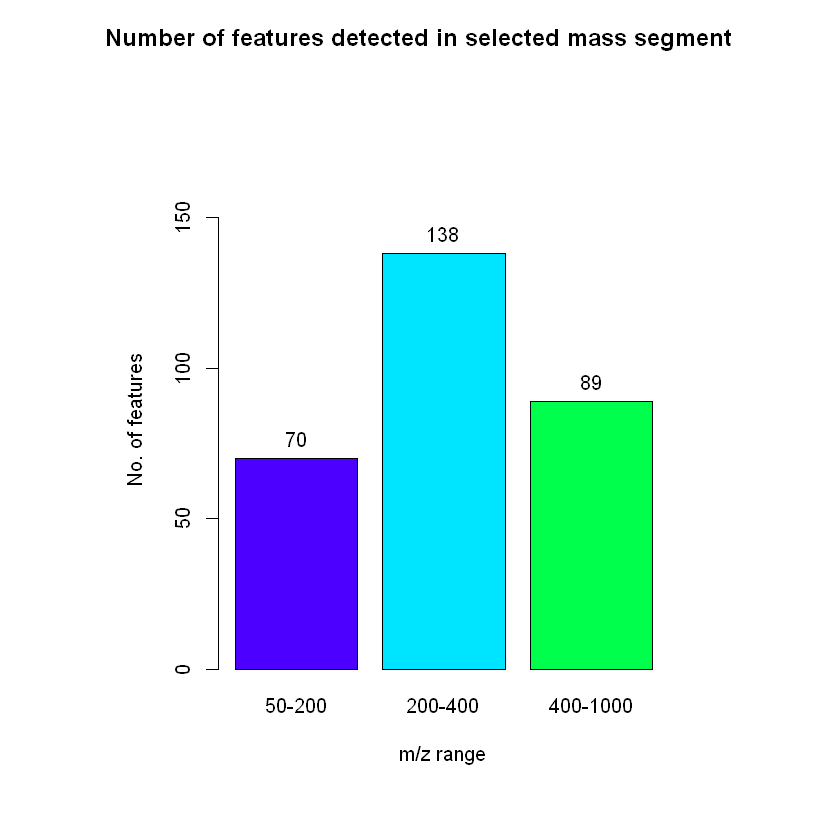

In [9]:
low_mass <- sum(as.numeric(alt_pos_norm$mz)<200)
mid_mass <- sum(as.numeric(alt_pos_norm$mz)>200 & as.numeric(alt_pos_norm$mz)<400)
high_mass <- sum(as.numeric(alt_pos_norm$mz)>400 & as.numeric(alt_pos_norm$mz)<1000)

data <- data.frame(x=c("50-200", "200-400", "400-1000"), 
                   y=c(low_mass,mid_mass,high_mass))
#data$y <- c(70,138,89)
ylimit <- c(0, 1.2*max(data$y))
par(oma=c(2,5,3,5))
xx <- barplot(data$y, 
              names.arg=data$x, 
              ylim=ylimit,
              ylab="No. of features", 
              xlab="m/z range",
              col=topo.colors(6))
text(x=xx,
     y=data$y,
     label=data$y,
     pos = 3)
title("Number of features detected in selected mass segment", outer = TRUE)

### Seperate

* Read input

In [10]:
nL_low <- countLines("data/low_pos.csv")
nL_low = read.csv("data/low_pos.csv", 
                skip=nL_low-1,
                fill=TRUE,
                sep="")
pos_low = read.csv("data/low_pos.csv", 
               header = FALSE, comment.char="#",
               stringsAsFactors = FALSE, 
               fill=TRUE, 
               col.names= paste0("V",seq_len(length(nL_low))), 
               sep="")

nL_high <- countLines("data/high_pos.csv")
nL_high = read.csv("data/high_pos.csv", 
                skip=nL_high-1,
                fill=TRUE,
                sep="")
pos_high = read.csv("data/high_pos.csv", 
               header = FALSE, comment.char="#",
               stringsAsFactors = FALSE, 
               fill=TRUE, 
               col.names= paste0("V",seq_len(length(nL_high))), 
               sep="")
dim(pos_low)
dim(pos_high)

[1] 24675   227

[1] 42055   227

* Parse files

In [11]:
pos_low <- Parse(pos_low)
pos_high <- Parse(pos_high)
cat("Size of low mass range matrix:", dim(pos_low), "\n")
cat("Size of high mass range matrix: ", dim(pos_high))
head(pos_low)

Size of low mass range matrix: 24631 46 
Size of high mass range matrix:  42011 46

,mz,rt,001_CRa_H9M5_M470_Blank_01_low_pos.featureXML,002_CRa_H9M5_M470_Pool_01_low_pos.featureXML,003_CRa_H9M5_M470_Pool_02_low_pos.featureXML,005_CRa_H9M5_M470_Blank_02_low_pos.featureXML,006_CRa_H9M5_M470_H01_K1_low_pos.featureXML,007_CRa_H9M5_M470_L01_K2_low_pos.featureXML,008_CRa_H9M5_M470_H14_K1_low_pos.featureXML,009_CRa_H9M5_M470_Blank_03_low_pos.featureXML,...,037_CRa_H9M5_M470_Blank_09_low_pos.featureXML,038_CRa_H9M5_M470_L14_K3_low_pos.featureXML,039_CRa_H9M5_M470_C03_K2_low_pos.featureXML,040_CRa_H9M5_M470_L03_K1_low_pos.featureXML,041_CRa_H9M5_M470_Blank_10_low_pos.featureXML,042_CRa_H9M5_M470_Pool_06_low_pos.featureXML,044_CRa_H9M5_M470_L14_K1_low_pos.featureXML,045_CRa_H9M5_M470_L14_K2_low_pos.featureXML,046_CRa_H9M5_M470_H03_K3_low_pos.featureXML,047_CRa_H9M5_M470_Blank_11_low_pos.featureXML
23062,53.0024162975483,115.2976,NaN,NaN,NaN,2119.8701171875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13768,53.00241850417,185.40725,NaN,2173.5400390625,NaN,3113.81005859375,NaN,5794.89990234375,3618.71997070312,NaN,...,NaN,2827.02001953125,NaN,1247.43994140625,NaN,NaN,NaN,NaN,2446.51000976562,NaN
1132,53.0024202052847,210.865984615385,6043.919921875,1851.81005859375,4448.64013671875,1696.84997558594,2620.51000976562,3599.42993164062,8359.0400390625,1209.35998535156,...,2005.32995605469,4416.240234375,5844.56005859375,4703.06005859375,7195.35009765625,1784.22998046875,3809.96997070312,2950.8701171875,1485.08996582031,4438.669921875
11805,53.0024205428948,206.807785714286,NaN,13719.400390625,NaN,NaN,NaN,3080.7900390625,NaN,NaN,...,NaN,1824.18005371094,NaN,NaN,4114.81005859375,2579.48999023438,1899.02001953125,NaN,NaN,2544.1298828125
16149,53.0024217236663,133.39722,NaN,4349.06005859375,NaN,1942.73999023438,NaN,NaN,NaN,NaN,...,1374.53002929688,NaN,NaN,NaN,NaN,NaN,6495.9599609375,NaN,NaN,2091.080078125
3365,53.0024232573282,196.17312,NaN,4931.759765625,4003.90991210938,2641.60009765625,10503.900390625,1839.67004394531,3256.96997070312,2057.76000976562,...,NaN,3495.4599609375,NaN,NaN,2193.97998046875,2393.830078125,5846.25,NaN,2788.48999023438,2350.830078125


* Rename columns

In [12]:
pos_low <- renameColumns(pos_low)
pos_high <- renameColumns(pos_high)

if (ncol(pos_low)!=ncol(pos_high)) {
    if (ncol(pos_low>ncol(pos_high))) {
        warning("Samples are missing in the high mass range")
    } else {
        warning("Samples are missing in the low mass range")
    }
}

print(names(pos_low))

 [1] "mz"       "rt"       "Blank_01" "Pool_01"  "Pool_02"  "Blank_02"
 [7] "H01_K1"   "L01_K2"   "H14_K1"   "Blank_03" "L03_K3"   "C14_K2"  
[13] "C01_K1"   "Blank_04" "Pool_03"  "H14_K2"   "H01_K2"   "H03_K1"  
[19] "Blank_05" "C01_K3"   "C14_K3"   "L03_K2"   "Blank_06" "Pool_04" 
[25] "C03_K1"   "H03_K2"   "H14_K3"   "Blank_07" "L01_K3"   "C14_K1"  
[31] "H01_K3"   "Blank_08" "Pool_05"  "L01_K1"   "C01_K2"   "C03_K3"  
[37] "Blank_09" "L14_K3"   "C03_K2"   "L03_K1"   "Blank_10" "Pool_06" 
[43] "L14_K1"   "L14_K2"   "H03_K3"   "Blank_11"


* Concatenate the scan ranges

In [13]:
pos_sep <- rbind(pos_low, pos_high[,names(pos_low)])
names(pos_sep)<-gsub("_",".",names(pos_sep))
cat("Number of features: ", nrow(pos_sep))

pos_sep[pos_sep=="NaN"]=NA
pos_sep <- data.frame(apply(pos_sep,2,as.numeric))

Number of features:  66642

* Blank Filter and ConsensusMap normalization

In [14]:
blankFilterPassed = 20 #Percentage, if the median blank intesity is more than X% of the sample intensity --> contaminant 
pos_sep <- blankFilter(pos_sep,blankFilterPassed)

# set parameters for normalization
ignoreColsPattern = c("TCA", "Blank")
method = "mean"
outlier = c(0.68, 1/0.68)
verbose = FALSE

pos_sep_norm <- consensusMapNormalization(pos_sep, ignoreColsPattern, method, outlier, verbose)

644 number of features passed 


* Filtering on pools, RSD and biological replicates and handle missing values

In [15]:
# set parameters
poolFilterCount = 5
biolReplFilterCount = 2
numReplicates = 3
maxRSD = 25

pos_sep_norm <- QAFilter(pos_sep_norm$df, poolFilterCount, biolReplFilterCount, numReplicates, maxRSD)
cat(nrow(pos_sep_norm), "number of features left")

# Handle missing values
pos_sep_norm <- missingValues(pos_sep_norm)

428 number of features left

* Plot figure 3

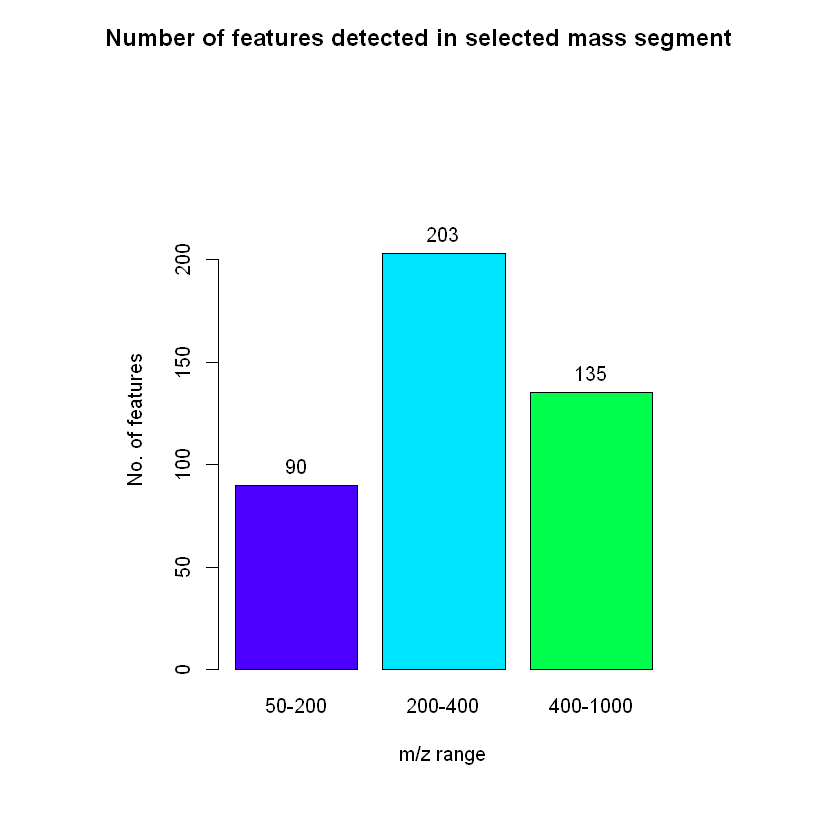

In [16]:
low_mass <- sum(as.numeric(pos_sep_norm$mz)<200)
mid_mass <- sum(as.numeric(pos_sep_norm$mz)>200 & as.numeric(pos_sep_norm$mz)<400)
high_mass <- sum(as.numeric(pos_sep_norm$mz)>400 & as.numeric(pos_sep_norm$mz)<1000)

data <- data.frame(x=c("50-200", "200-400", "400-1000"), 
                   y=c(low_mass,mid_mass,high_mass))
#data$y <- c(90,204,134)
ylimit <- c(0, 1.2*max(data$y))
par(oma=c(2,5,3,5))
xx <- barplot(data$y, 
              names.arg=data$x, 
              ylim=ylimit,
              ylab="No. of features", 
              xlab="m/z range",
              col=topo.colors(6))
text(x=xx,
     y=data$y,
     label=data$y,
     pos = 3)
title("Number of features detected in selected mass segment", outer = TRUE)

### Full scan approach

In [17]:
nL <- countLines("data/ges_pos.csv")
nL = read.csv("data/ges_pos.csv", 
                skip=nL-1,
                fill=TRUE,
                sep="")
full_pos = read.csv("data/ges_pos.csv", 
               header = FALSE, comment.char="#",
               stringsAsFactors = FALSE, 
               fill=TRUE, 
               col.names= paste0("V",seq_len(length(nL))), 
               sep="")
dim(full_pos)

[1] 26211   227

* Parse file

In [18]:
full_pos <- Parse(full_pos)
cat("Size of high mass range matrix: ", dim(full_pos))
head(full_pos)

Size of high mass range matrix:  26167 46

,mz,rt,001_CRa_H9M5_M470_Blank_01_ges_pos.featureXML,002_CRa_H9M5_M470_Pool_01_ges_pos.featureXML,003_CRa_H9M5_M470_Pool_02_ges_pos.featureXML,005_CRa_H9M5_M470_Blank_02_ges_pos.featureXML,006_CRa_H9M5_M470_H01_K1_ges_pos.featureXML,007_CRa_H9M5_M470_L01_K2_ges_pos.featureXML,008_CRa_H9M5_M470_H14_K1_ges_pos.featureXML,009_CRa_H9M5_M470_Blank_03_ges_pos.featureXML,...,037_CRa_H9M5_M470_Blank_09_ges_pos.featureXML,038_CRa_H9M5_M470_L14_K3_ges_pos.featureXML,039_CRa_H9M5_M470_C03_K2_ges_pos.featureXML,040_CRa_H9M5_M470_L03_K1_ges_pos.featureXML,041_CRa_H9M5_M470_Blank_10_ges_pos.featureXML,042_CRa_H9M5_M470_Pool_06_ges_pos.featureXML,044_CRa_H9M5_M470_L14_K1_ges_pos.featureXML,045_CRa_H9M5_M470_L14_K2_ges_pos.featureXML,046_CRa_H9M5_M470_H03_K3_ges_pos.featureXML,047_CRa_H9M5_M470_Blank_11_ges_pos.featureXML
20748,53.038799721998,188.95125,NaN,NaN,4653.64013671875,5143.7099609375,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2735.81005859375,NaN
24450,53.0388044647364,235.9331,NaN,NaN,1538.07995605469,2628.68994140625,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1578.26000976562,NaN
24572,53.0388078670139,212.8855,NaN,NaN,NaN,5250.830078125,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1230.26000976562,NaN
26108,55.0180718024992,573.6858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2646.17993164062,NaN,NaN
23606,55.0418584210493,706.789714285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2674.90991210938,NaN,NaN,NaN,NaN,NaN,8145.990234375,NaN,3427.26000976562,NaN
14703,55.0418605742001,530.650107692308,NaN,NaN,NaN,NaN,NaN,1968.48999023438,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2868.01000976562,NaN,1229.17004394531,1631.43994140625


* Rename columns

In [19]:
full_pos <- renameColumns(full_pos)
print(names(full_pos))

 [1] "mz"       "rt"       "Blank_01" "Pool_01"  "Pool_02"  "Blank_02"
 [7] "H01_K1"   "L01_K2"   "H14_K1"   "Blank_03" "L03_K3"   "C14_K2"  
[13] "C01_K1"   "Blank_04" "Pool_03"  "H14_K2"   "H01_K2"   "H03_K1"  
[19] "Blank_05" "C01_K3"   "C14_K3"   "L03_K2"   "Blank_06" "Pool_04" 
[25] "C03_K1"   "H03_K2"   "H14_K3"   "Blank_07" "L01_K3"   "C14_K1"  
[31] "H01_K3"   "Blank_08" "Pool_05"  "L01_K1"   "C01_K2"   "C03_K3"  
[37] "Blank_09" "L14_K3"   "C03_K2"   "L03_K1"   "Blank_10" "Pool_06" 
[43] "L14_K1"   "L14_K2"   "H03_K3"   "Blank_11"


In [20]:
names(full_pos)<-gsub("_",".",names(full_pos))
cat("Number of features: ", nrow(full_pos))

full_pos[full_pos=="NaN"]=NA
full_pos <- data.frame(apply(full_pos,2,as.numeric))

Number of features:  26167

* Blank Filter and ConsensusMap normalization

In [21]:
blankFilterPassed = 20 #Percentage, if the median blank intesity is more than X% of the sample intensity --> contaminant 
full_pos <- blankFilter(full_pos,blankFilterPassed)

# set parameters for normalization
ignoreColsPattern = c("TCA", "Blank")
method = "mean"
outlier = c(0.68, 1/0.68)
verbose = FALSE

full_pos_norm <- consensusMapNormalization(full_pos, ignoreColsPattern, method, outlier, verbose)

285 number of features passed 


* Filtering on pools, RSD and biological replicates and handle missing values

In [22]:
# set parameters
poolFilterCount = 5
biolReplFilterCount = 2
numReplicates = 3
maxRSD = 25

full_pos_norm <- QAFilter(full_pos_norm$df, poolFilterCount, biolReplFilterCount, numReplicates, maxRSD)
cat(nrow(full_pos_norm), "number of features left")

# Handle missing values
full_pos_norm <- missingValues(full_pos_norm)

231 number of features left

* Plot figure 3

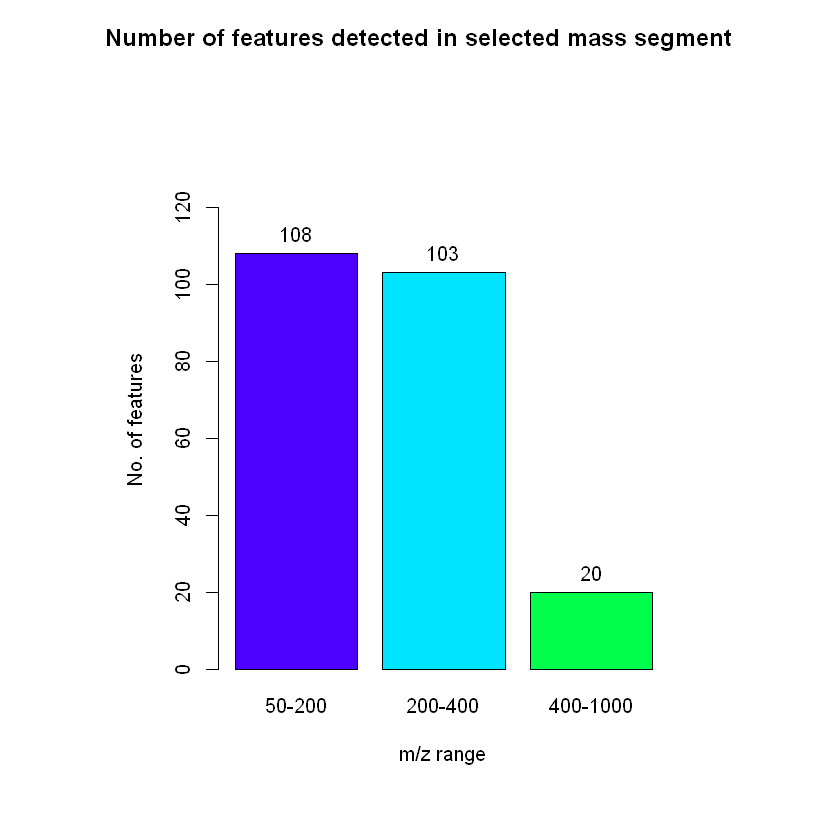

In [23]:
low_mass <- sum(as.numeric(full_pos_norm$mz)<200)
mid_mass <- sum(as.numeric(full_pos_norm$mz)>200 & as.numeric(full_pos_norm$mz)<400)
high_mass <- sum(as.numeric(full_pos_norm$mz)>400 & as.numeric(full_pos_norm$mz)<1000)

data <- data.frame(x=c("50-200", "200-400", "400-1000"), 
                   y=c(low_mass,mid_mass,high_mass))
#data$y <- c(108,103,20)
ylimit <- c(0, 1.2*max(data$y))
par(oma=c(2,5,3,5))
xx <- barplot(data$y, 
              names.arg=data$x, 
              ylim=ylimit,
              ylab="No. of features", 
              xlab="m/z range",
              col=topo.colors(6))
text(x=xx,
     y=data$y,
     label=data$y,
     pos = 3)
title("Number of features detected in selected mass segment", outer = TRUE)

In [24]:
length(duplicated(rbind(full_pos_norm,pos_sep_norm, fromLast=TRUE)))

[1] 660

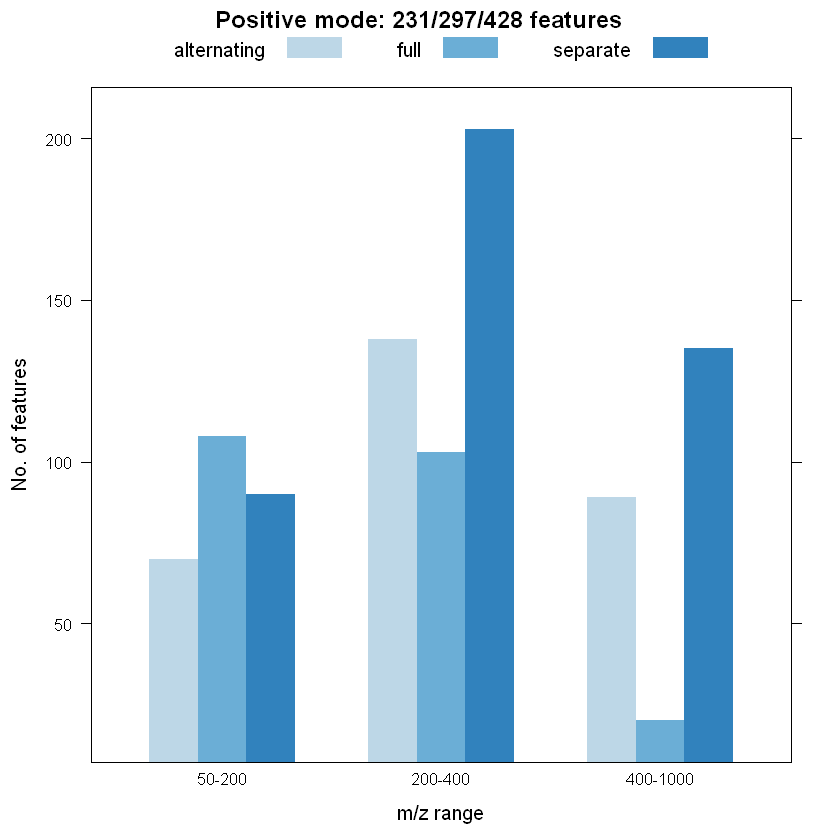

In [25]:
low_mass <- sum(as.numeric(alt_pos_norm$mz)<200)
mid_mass <- sum(as.numeric(alt_pos_norm$mz)>200 & as.numeric(alt_pos_norm$mz)<400)
high_mass <- sum(as.numeric(alt_pos_norm$mz)>400 & as.numeric(alt_pos_norm$mz)<1000)
alt <- data.frame(x=c("50-200", "200-400", "400-1000"), 
                   y=c(low_mass,mid_mass,high_mass))
alt$Category <- rep("alternating", nrow(alt))

low_mass <- sum(as.numeric(pos_sep_norm$mz)<200)
mid_mass <- sum(as.numeric(pos_sep_norm$mz)>200 & as.numeric(pos_sep_norm$mz)<400)
high_mass <- sum(as.numeric(pos_sep_norm$mz)>400 & as.numeric(pos_sep_norm$mz)<1000)
sep <- data.frame(x=c("50-200", "200-400", "400-1000"), 
                   y=c(low_mass,mid_mass,high_mass))
sep$Category <- rep("separate", nrow(sep))

low_mass <- sum(as.numeric(full_pos_norm$mz)<200)
mid_mass <- sum(as.numeric(full_pos_norm$mz)>200 & as.numeric(full_pos_norm$mz)<400)
high_mass <- sum(as.numeric(full_pos_norm$mz)>400 & as.numeric(full_pos_norm$mz)<1000)
full <- data.frame(x=c("50-200", "200-400", "400-1000"), 
                   y=c(low_mass,mid_mass,high_mass))
full$Category <- rep("full", nrow(full))

data <- data.frame(rbind(alt,sep,full))
data$x <- factor(data$x, levels=c("50-200", "200-400", "400-1000"))


library(RColorBrewer)
myColours <- brewer.pal(5,"Blues")

my.settings <- list(
  superpose.polygon=list(col=myColours[2:5], border="transparent"),
  strip.background=list(col=myColours[6]),
  strip.border=list(col="black")
)

library(lattice)
ylimit <- c(0, 1.2*max(data$y))
#par(oma=c(2,5,3,5))
barchart(y~x,data = data,groups=Category,
        scales=list(cex=0.8), auto.key=list(space="top", columns=3),
        main = "Positive mode: 231/297/428 features",
        par.settings = my.settings,
        ylab="No. of features", xlab="m/z range"
        )


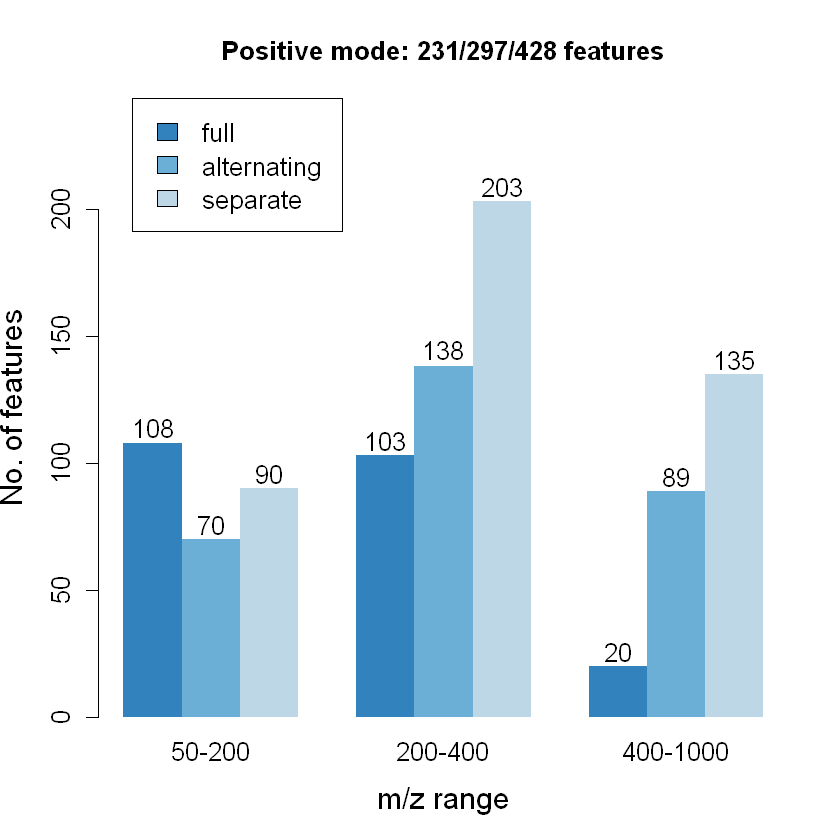

In [39]:
low_mass <- sum(as.numeric(alt_pos_norm$mz)<200)
mid_mass <- sum(as.numeric(alt_pos_norm$mz)>200 & as.numeric(alt_pos_norm$mz)<400)
high_mass <- sum(as.numeric(alt_pos_norm$mz)>400 & as.numeric(alt_pos_norm$mz)<1000)
alt <- data.frame(low_mass,mid_mass,high_mass)
names(alt) <- c("50-200", "200-400", "400-1000")
row.names(alt) <- "alternating"                

low_mass <- sum(as.numeric(pos_sep_norm$mz)<200)
mid_mass <- sum(as.numeric(pos_sep_norm$mz)>200 & as.numeric(pos_sep_norm$mz)<400)
high_mass <- sum(as.numeric(pos_sep_norm$mz)>400 & as.numeric(pos_sep_norm$mz)<1000)
sep <- data.frame(low_mass,mid_mass,high_mass)
names(sep) <- c("50-200", "200-400", "400-1000")
row.names(sep) <- "separate"  

low_mass <- sum(as.numeric(full_pos_norm$mz)<200)
mid_mass <- sum(as.numeric(full_pos_norm$mz)>200 & as.numeric(full_pos_norm$mz)<400)
high_mass <- sum(as.numeric(full_pos_norm$mz)>400 & as.numeric(full_pos_norm$mz)<1000)
full <- data.frame(low_mass,mid_mass,high_mass)
names(full) <- c("50-200", "200-400", "400-1000")
row.names(full) <- "full"  

data <- data.frame(rbind(full,alt,sep))
names(data) <- c("50-200", "200-400", "400-1000")

library(RColorBrewer)
myColours <- brewer.pal(5,"Blues")

ylimit <- c(0, 1.2*max(data))
#par(oma=c(2,5,3,5))
xx<-barplot(as.matrix(data), col= rev(brewer.pal(5,"Blues")[c(2,3,4)]), width=2, beside=TRUE,border=NA,
        ylab="No. of features", xlab="m/z range", ylim=ylimit, main="Positive mode: 231/297/428 features",
            cex.axis=1.3, cex.names=1.3, cex.lab=1.5, cex.main=1.3)
legend("topleft",inset=c(0.05,0), fill=rev(brewer.pal(5,"Blues")[c(2,3,4)]), legend=rownames(data), cex=1.3)

test <- c(108,70,90,103,138,203,20,89,135)
text(c(3,5,7),c(114,76,96),c("108","70","90"),cex=1.3)
text(c(11,13,15),c(109,145,209),c("103","138","203"),cex=1.3)
text(c(19,21,23),c(26,95,141),c("20","89","135"),cex=1.3)


In [26]:
save.image("downstream_pos.RData")